In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)

batch_size = 100
n_channel = 100
n_epoch = 100
image_size = 28 * 28 * 1

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
root = './data'
mnist_dataset = datasets.FashionMNIST(root=root,download=True,train=True,transform=transform)
dataloader = DataLoader(mnist_dataset,batch_size=batch_size,shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device,image_size,sep="\n")



cpu
784


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Linear(n_channel, 128)
        self.conv2 = nn.Linear(128, 256)
        self.conv3 = nn.Linear(256, image_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = 2 * self.sigmoid(2*x) - 1
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Linear(image_size, 256)
        self.conv2 = nn.Linear(256, 128)
        self.conv3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.view(-1,image_size)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.sigmoid(x)
        return x.squeeze()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

Epoch:1/100, Loss_D: 0.612, Loss_G: 0.837, D(x): 0.956, D(G(z)): 0.433/0.433
Epoch:10/100, Loss_D: 0.299, Loss_G: 2.139, D(x): 0.861, D(G(z)): 0.117/0.119
Epoch:20/100, Loss_D: 0.207, Loss_G: 2.908, D(x): 0.928, D(G(z)): 0.056/0.055
Epoch:30/100, Loss_D: 0.044, Loss_G: 3.953, D(x): 0.985, D(G(z)): 0.025/0.019
Epoch:40/100, Loss_D: 0.065, Loss_G: 3.907, D(x): 0.976, D(G(z)): 0.030/0.021
Epoch:50/100, Loss_D: 0.174, Loss_G: 4.107, D(x): 0.971, D(G(z)): 0.093/0.020
Epoch:60/100, Loss_D: 0.150, Loss_G: 3.199, D(x): 0.933, D(G(z)): 0.039/0.044
Epoch:70/100, Loss_D: 0.198, Loss_G: 3.679, D(x): 0.941, D(G(z)): 0.058/0.034
Epoch:80/100, Loss_D: 0.241, Loss_G: 2.786, D(x): 0.909, D(G(z)): 0.032/0.083
Epoch:90/100, Loss_D: 0.174, Loss_G: 3.326, D(x): 0.923, D(G(z)): 0.016/0.048
Epoch:100/100, Loss_D: 0.098, Loss_G: 3.840, D(x): 0.961, D(G(z)): 0.038/0.026


In [ ]:
criterion = nn.BCELoss()
optimizerG = optim.SGD(generator.parameters(),lr = 0.001)
optimizerD = optim.SGD(discriminator.parameters(),lr = 0.001)

G_losses = []
D_losses = []
D_x_list = []
D_G_z1_list = []
D_G_z2_list = []

In [ ]:
# 学習のループ
for epoch in range(n_epoch):
    for x, t in dataloader:
        # 前準備
        real_image = x.view(-1,image_size).to(device) # 本物の画像データ
        noise = torch.randn(batch_size,n_channel,device=device) # ノイズ作成
        real_target = torch.full((batch_size,), 1., device=device) # 本物ラベル
        fake_target = torch.full((batch_size,), 0., device=device) # 偽物ラベル

        # discriminatorの学習(本物画像の学習)
        discriminator.zero_grad()
        y = discriminator(real_image)
        errD_real = criterion(y, real_target)
        D_x = y.mean().item()

        # discriminatorの学習(偽物画像の学習)
        fake_image = generator(noise)
        y = discriminator(fake_image.detach())
        errD_fake = criterion(y, fake_target)
        D_G_z1 = y.mean().item()

        # discriminatorの更新
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()     

        # generatorの学習
        generator.zero_grad()
        y = discriminator(fake_image)
        errG = criterion(y, real_target)
        errG.backward()
        D_G_z2 = y.mean().item()
        optimizerG.step()

        # 損失関数のリスト作成
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        D_x_list.append(D_x)
        D_G_z1_list.append(D_G_z1)
        D_G_z1_list.append(D_G_z2)

    if (epoch+1) == 1 or (epoch+1) % 10 == 0:
        print('Epoch:{}/{}, Loss_D: {:.3f}, Loss_G: {:.3f}, D(x): {:.3f}, D(G(z)): {:.3f}/{:.3f}'
        .format(epoch + 1, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

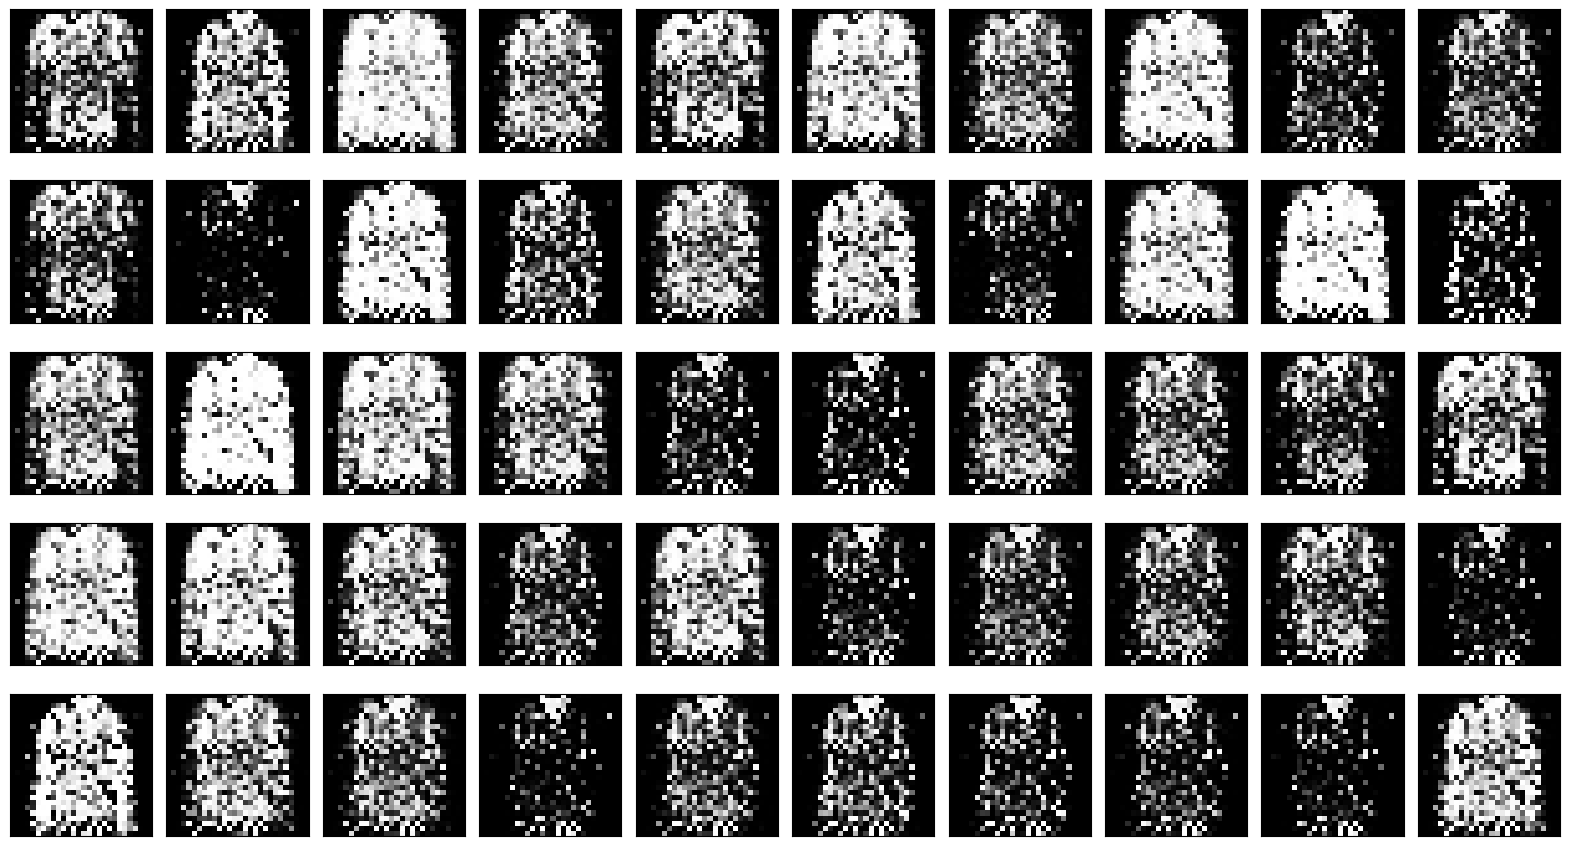

In [3]:
# fake_image作成
generator = generator.to("cpu")
generator.eval
noise = torch.randn(10000, 100)
y = generator(noise)

torch.save(y,"./data/plain_data_FashionMNIST.pt")
torch.save(generator.to("cpu"),"./data/FashionMNIST_generator.pth")
torch.save(noise,"./data/noize.pt")

# fake_image可視化
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
    ax.imshow(y[i,].view(28,28).detach(), "gray")


Memory Usage: -455954432 bytes
CPU Usage: -24.6%
Time: 98.10469217199989
Memory Usage: 786829312 bytes
CPU Usage: 69.7%
Time: 16.936801894999917
Memory Usage: 57344 bytes
CPU Usage: 6.4%
Time: 23.07125658699988


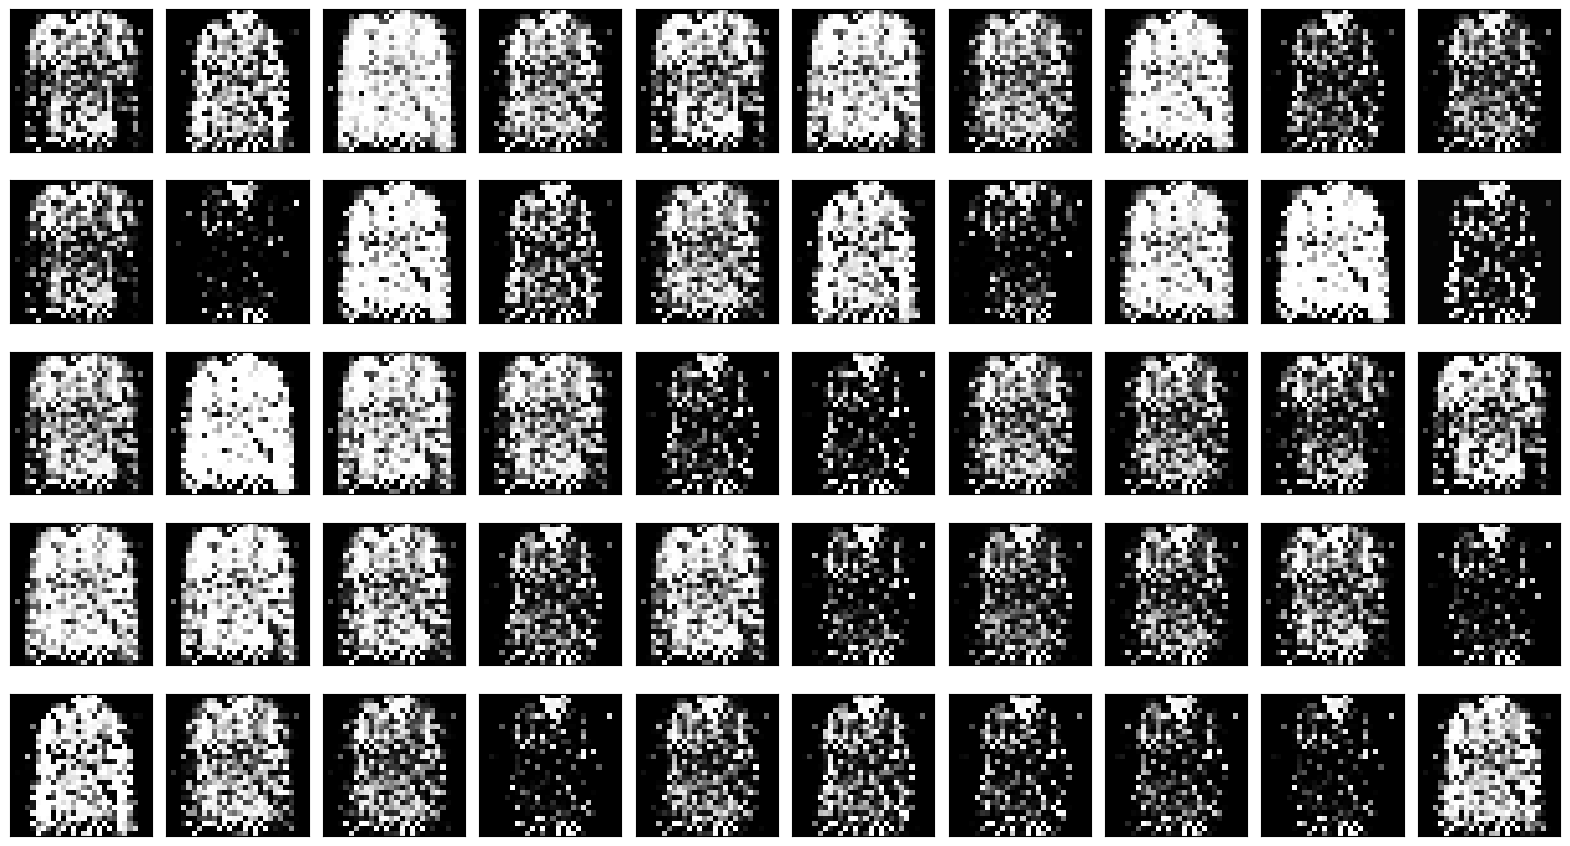

In [11]:
from concrete.ml.torch.compile import compile_torch_model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import psutil
import time
import numpy as np

def measure(start,start_memory=None, start_cpu=None, start_time=None):
    if start:
        start_memory = psutil.virtual_memory().used
        start_cpu = psutil.cpu_percent(interval=None)
        start_time = time.perf_counter()
        return start_memory, start_cpu, start_time
    else:
        end_memory = psutil.virtual_memory().used
        end_cpu = psutil.cpu_percent(interval=None)
        end_time = time.perf_counter()
        
        me_momory = end_memory - start_memory
        me_cpu = end_cpu - start_cpu
        me_time = end_time - start_time

        print(f"Memory Usage: {me_momory} bytes")
        print(f"CPU Usage: {me_cpu}%")
        print(f"Time: {me_time}")

n_channel = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Linear(n_channel, 128)
        self.conv2 = nn.Linear(128, 256)
        self.conv3 = nn.Linear(256, image_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = 2 * self.sigmoid(2*x) - 1
        return x

generator = Generator
generator = torch.load("/home/soto/concreteml/data/FashionMNIST_generator.pth")
noise = torch.load("./data/noize.pt")
noisex = torch.randn(100,100)

n_bits_qat = 6
#modelの作成
start_memory, start_cpu, start_time = measure(True)
quantized_module = compile_torch_model(
    generator,
    noisex,
    n_bits=n_bits_qat, 
)
measure(False,start_memory, start_cpu, start_time )


# Generate keys first
start_memory, start_cpu, start_time = measure(True)
quantized_module.fhe_circuit.keygen()
measure(False,start_memory, start_cpu, start_time )

noise = noise.numpy()
#暗号化モデルの実行
start_memory, start_cpu, start_time = measure(True)
predictions = quantized_module.forward(noise, fhe="simulate")
measure(False,start_memory, start_cpu, start_time )

predictions = torch.tensor(predictions)
torch.save(predictions,"./data/concreteml_data_FashionMNIST.pt")
# fake_imageの可視化
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
        # 画像のサイズを修正する
    img = predictions[i,].view(1, 28, 28).cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))  # チャンネルの順番を変更
    ax.imshow(img,cmap='gray')

20.02154541015625
-22.709644317626953


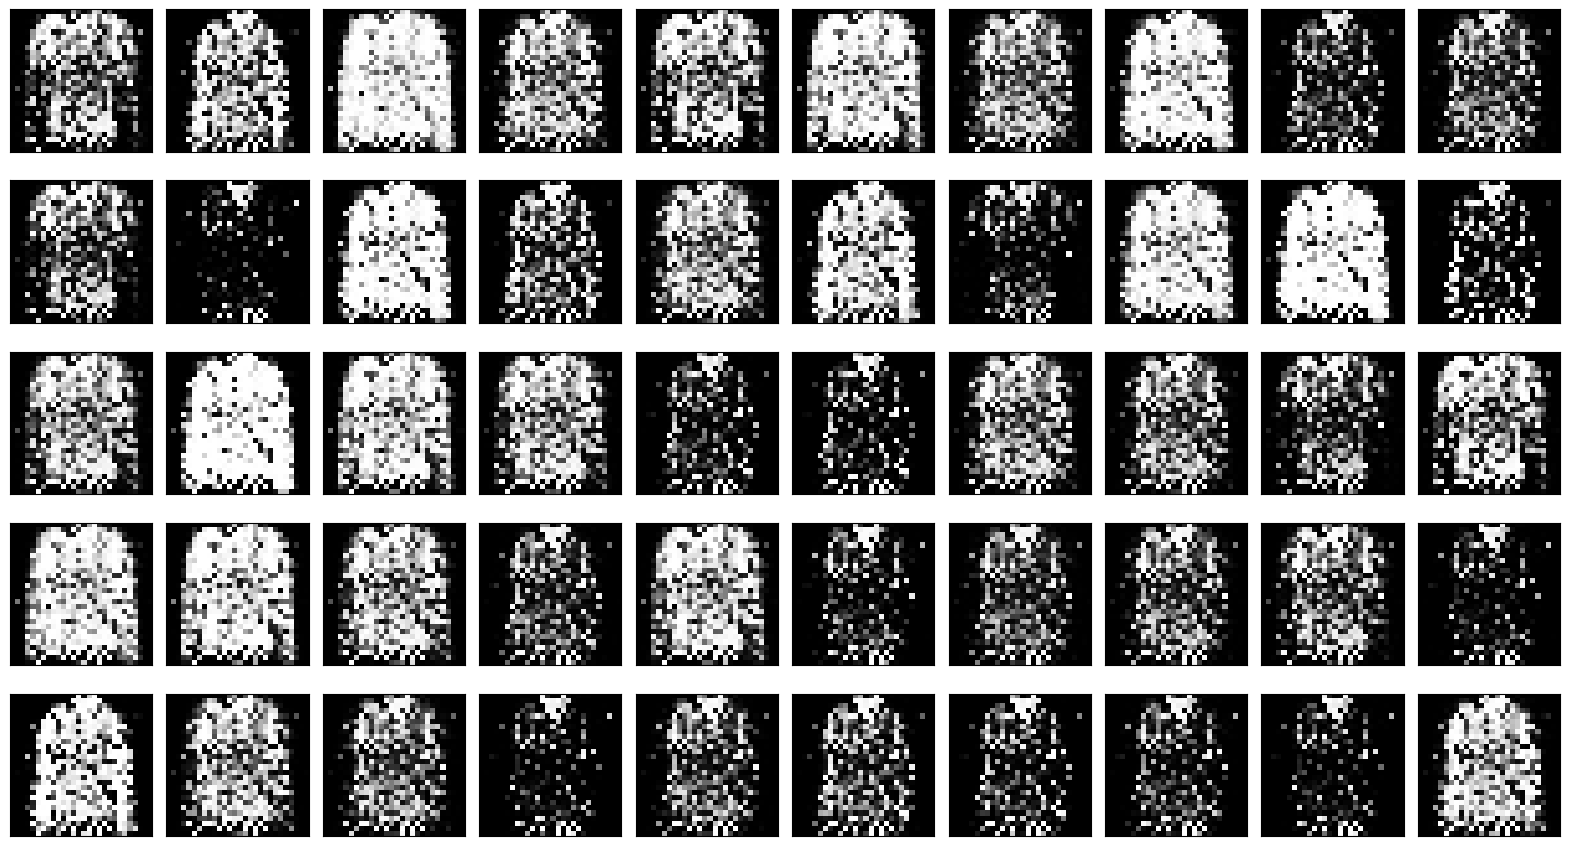

In [12]:
import torch
import torch.nn as nn
import numpy
import matplotlib.pyplot as plt

max_min = []
image_size = 28*28
n_channel = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Linear(n_channel, 128)
        self.conv2 = nn.Linear(128, 256)
        self.conv3 = nn.Linear(256, image_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        # グローバル変数を変更するためにglobalキーワードを使用
        global max_min
        # テンソル全体の最大値と最小値を取得
        max_val = torch.max(x).item()
        min_val = torch.min(x).item()
        max_min = [max_val, min_val]
        
        x = 2 * self.sigmoid(2*x) - 1
        return x


generator = Generator()
generator = torch.load("/home/soto/concreteml/data/FashionMNIST_generator.pth")
noise = torch.load("./data/noize.pt")
y = generator(noise)

print(max(max_min), min(max_min), sep="\n")
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
    ax.imshow(y[i,].view(28,28).cpu().detach(), "gray")
